# <center>Network Science</center>

## <center/>Project #2

# Description

Consider the [flickr dataset](https://www.hse.ru/data/2016/05/17/1128901463/flickr_data.tar.gz) (warning, raw data!). <br/>
File ''*users.txt*'' provides a table of form *userID*, *enterTimeStamp*, *additionalInfo*... <br/>
File "*contacts.txt*" consists of pairs of *userID*'s and link establishment timestamp <br/>

Recall *scoring functions* and graph embeddings for link prediction. Your task is to compare the performance of each scoring function as follows:
1. TOP-$n$ accuracy
    * Denote the number of links $E_\text{new}$ appeared during testing period as $n$
    * Denote the ranked list of node pairs provided by score $s$ as $\hat{E}_s$
    * Take top-$n$ pairs from $\hat{E}_s$ and intersect it with $E_\text{new}$. Performance is measured as the size of resulted set
2. ROC and AUC ('star' subtask)

Essentially, for this task you also have to follow the guideline points $1$ and $2$ above. The only thing you have to keep in mind is that flickr dataset is growing dataset. Since then, consider nodes that are significantly represented both in training and testing intervals (have at least $5$ adjacent edges in training and testing intervals)

## Solution

Import some useful libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.xkcd()
import networkx as nx
%matplotlib inline
import pandas as pd

### Prepare for binary classification problem

Download our dataset:

In [2]:
## download dataset
flickr = pd.read_csv('contacts.txt', header=None, sep=' ')
flickr.columns = ['u1', 'u2', 'time']
## delete negative time data
flickr = flickr[~ (flickr['time'] < 0) ]
## leave nodes with degree >= 5
hist = flickr.stack().value_counts()
sign_nodes = hist[ hist > 4 ].keys()
flickr = flickr[ (flickr['u1'].isin(sign_nodes) & flickr['u2'].isin(sign_nodes)) ]

flickr.head(3)

,u1,u2,time
0,41,42,29252304
1,41,44,24407893
2,41,46,28952340


Determine datasets with training and testing (gap in the center of time interval) intervals:

In [3]:
train_int = flickr[ (flickr['time'] <= np.median(flickr['time'])) ].drop_duplicates()
test_int = flickr[ (flickr['time'] > np.median(flickr['time'])) ].drop_duplicates()

del train_int['time']
del test_int['time']

Testing interval should include only authors that have appeared during training interval. Let's find positive examples - we need to find author pairs that haven't been formed during training interval but have been formed by testing interval:

In [4]:
## unique users in training and testing intervals and their intersection
unique_train = pd.concat([train_int['u1'], train_int['u2']]).unique()
unique_test = pd.concat([test_int['u1'], test_int['u2']]).unique()
inter = np.intersect1d(unique_test, unique_train)
## find positive examples
pos = test_int[ (test_int['u1'].isin(inter) & test_int['u2'].isin(inter)) ]

Now we should find negative examples such as pairs of users that have not occured together during training and testing intervals. Since it is time-consuming process, we can restrict ourselves with 100,000 of negative examples:

In [2]:
## put your code here

So let's make dataset with 100,000 positive and 100,000 negative examples:

In [1]:
## put your code here

### Construct feature space

So now we got labels for our dataset from training interval. We should build graph of training interval to score some features for pairs of nodes from our labeled dataset. To construct feature space we can take some scoring functions from the lecture (all formulas are provided on slides). This functions reflect relations between each pair of nodes in our dataset and form **baselines**:

- Number of common neighbors

- Preferential attachment

- Jaccard’s coefficient

- Adamic/Adar

- Shortest path

In [9]:
## make graph of training interval
G_train = nx.Graph()
nx.from_pandas_dataframe(train_int, 'u1', 'u2', create_using = G_train)

In [10]:
def scoring(df, G):
    common_neighbors = []
    preferential_att = []
    jaccard = []
    adar = []
    shortest_path = []
    for r in df.iterrows():
        nb_v = set(G.neighbors(r[1][0]))
        nb_w = set(G.neighbors(r[1][1]))
        union = nb_v | nb_w
        inter = nb_v & nb_w
        ## Number of common neighbors
        common_neighbors.append(len(inter))
        ## Preferential attachment
        preferential_att.append(len(nb_v) + len(nb_w))
        ## Jaccard’s coefficient
        jaccard.append(len(inter) / len(union))
        ## Adamic/Adar
        a = 0
        for node in inter:
            a += 1.0 / np.log(G.degree(node))
        adar.append(a)
        ## Shortest path
        try:
            shortest_path.append(- nx.shortest_path_length(G, source = r[1][0], target = r[1][1]))
        except:
            shortest_path.append(- 10000)
    df['common_neighbors'] = pd.Series(common_neighbors, index = df.index)
    df['preferential_att'] = pd.Series(preferential_att, index = df.index)
    df['jaccard'] = pd.Series(jaccard, index = df.index)
    df['adar'] = pd.Series(adar, index = df.index)
    df['shortest_path'] = pd.Series(shortest_path, index = df.index)

In [11]:
scoring(posneg, G_train)

### TOP-n accuracy

So now we should do the following: for each scoring function let's take top-100000 pairs and intersect it with positive examples:

In [18]:
for score in ['common_neighbors', 
                'preferential_att', 
                'jaccard', 
                'adar',
                'shortest_path']:
    top_n = posneg.sort_values(score, ascending = False)[:100000]
    acc = len(pd.merge(pos_100000, top_n, how = 'inner', on = ['u1', 'u2'])) / 100000
    print('{}: {}'.format(score, acc))

common_neighbors: 0.72649
preferential_att: 0.79486
jaccard: 0.72649
adar: 0.72649
shortest_path: 0.73288


This rate represents perfomance of scoring functions: we see that preferential attachment gave us best prediction result, bur in general all scoring functions give quite high and similar result - about 70-80%.

### ROC and AUC

Let's also compute ROC and AUC:

For common_neighbors AUC = 0.18769141495000016
For preferential_att AUC = 0.12433481895000002
For jaccard AUC = 0.18281841495000017
For adar AUC = 0.18942946495000018
For shortest_path AUC = 0.17466675280000005


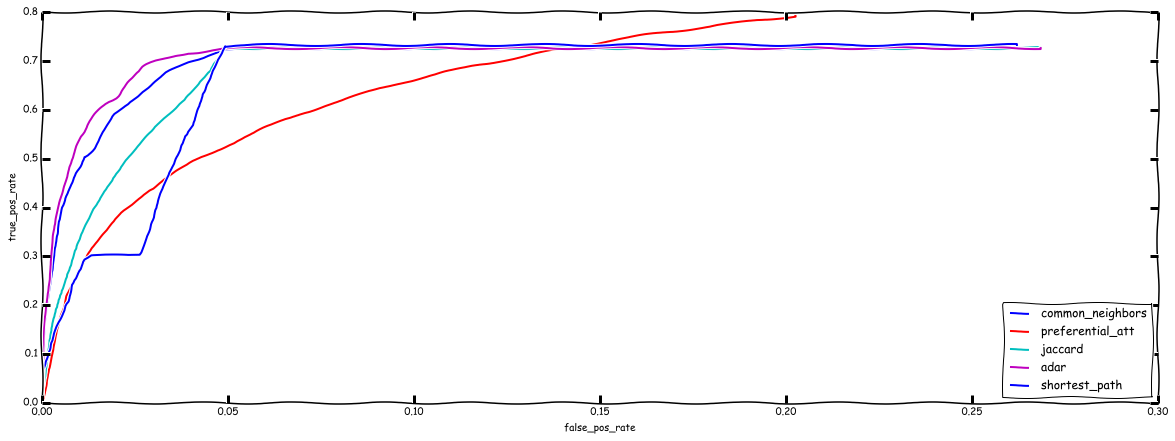

In [24]:
scores = ['common_neighbors', 
                'preferential_att', 
                'jaccard', 
                'adar',
                'shortest_path']

plt.figure(figsize=(20,7))

for score in scores:
    true_pos_rate = []
    false_pos_rate = []
    auc = 0
    sort_posneg = posneg.sort_values(score, ascending = False)
    for n in range(0, 100000, 500):
        top_n = sort_posneg[:n]
        
        tpr = len(pd.merge(pos_100000, top_n, how = 'inner', on = ['u1', 'u2'])) / 100000
        true_pos_rate.append(tpr)
        fpr = len(pd.merge(neg_100000, top_n, how = 'inner', on = ['u1', 'u2'])) / 100000
        false_pos_rate.append(fpr)
    for i in range(1, len(false_pos_rate)):
        auc += (false_pos_rate[i] - false_pos_rate[i-1]) * (true_pos_rate[i-1] +
                                                            true_pos_rate[i]) / 2
    plt.plot(false_pos_rate, true_pos_rate)
    print('For {} AUC = {}'.format(score, auc))
    
plt.xlabel('false_pos_rate')
plt.ylabel('true_pos_rate')
plt.legend(scores, loc = 'best')

ROC illustrates the performance of a binary classifier system as its discrimination threshold is varied. The curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The ROC curve is the sensitivity as a function of fall-out. AUC is computed as an area under the curve and is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one. As we see AUC i rather small for all scoring function (fit our top_n results).